In [1]:
# Imports
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import json
import os
from PIL import Image
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

In [2]:


# Step 1: Download the VQA v2 Dataset (only if not already downloaded)
if not os.path.exists("/content/VQA_dataset/train2014"):
    !mkdir -p /content/VQA_dataset/
    !wget -P /content/VQA_dataset/ http://images.cocodataset.org/zips/train2014.zip
    !wget -P /content/VQA_dataset/ http://images.cocodataset.org/zips/val2014.zip
    !wget -P /content/VQA_dataset/ https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip
    !wget -P /content/VQA_dataset/ https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip
    !wget -P /content/VQA_dataset/ https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Val_mscoco.zip
    !wget -P /content/VQA_dataset/ https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip
    !unzip -q /content/VQA_dataset/train2014.zip -d /content/VQA_dataset/
    !unzip -q /content/VQA_dataset/val2014.zip -d /content/VQA_dataset/
    !unzip -q /content/VQA_dataset/v2_Questions_Train_mscoco.zip -d /content/VQA_dataset/
    !unzip -q /content/VQA_dataset/v2_Annotations_Train_mscoco.zip -d /content/VQA_dataset/
    !unzip -q /content/VQA_dataset/v2_Questions_Val_mscoco.zip -d /content/VQA_dataset/
    !unzip -q /content/VQA_dataset/v2_Annotations_Val_mscoco.zip -d /content/VQA_dataset/
print("Files in /content/VQA_dataset:", os.listdir("/content/VQA_dataset/"))

--2025-03-01 20:12:55--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.16.24, 16.182.102.65, 3.5.25.78, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.16.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘/content/VQA_dataset/train2014.zip’

train2014.zip       100%[===================>]  12.58G  52.3MB/s    in 4m 36s  

2025-03-01 20:17:31 (46.7 MB/s) - ‘/content/VQA_dataset/train2014.zip’ saved [13510573713/13510573713]

--2025-03-01 20:17:31--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.29.131, 3.5.28.99, 3.5.27.123, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.29.131|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘/content/VQA_dataset/val2014.zip’

val2014.

In [3]:
# Paths
TRAIN_IMAGE_DIR = "/content/VQA_dataset/train2014/"
VAL_IMAGE_DIR = "/content/VQA_dataset/val2014/"
TRAIN_QUESTION_FILE = "/content/VQA_dataset/v2_OpenEnded_mscoco_train2014_questions.json"
TRAIN_ANNOTATION_FILE = "/content/VQA_dataset/v2_mscoco_train2014_annotations.json"
VAL_QUESTION_FILE = "/content/VQA_dataset/v2_OpenEnded_mscoco_val2014_questions.json"
VAL_ANNOTATION_FILE = "/content/VQA_dataset/v2_mscoco_val2014_annotations.json"

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset Class
class VQADataset(Dataset):
    def __init__(self, image_dir, question_file, annotation_file, transform=None, max_samples=None):
        self.image_dir = image_dir
        self.transform = transform
        with open(question_file, "r") as f:
            self.questions = json.load(f)["questions"]
        if max_samples:
            self.questions = self.questions[:max_samples]
        with open(annotation_file, "r") as f:
            self.annotations = json.load(f)["annotations"][:max_samples] if max_samples else json.load(f)["annotations"]
        self.vocab = self.build_vocab()
        self.answer_to_id = self.build_answer_vocab()

    def build_vocab(self):
        vocab = {"<PAD>": 0, "<UNK>": 1}
        index = 2
        for q in self.questions:
            for word in q["question"].lower().split():
                if word not in vocab:
                    vocab[word] = index
                    index += 1
        return vocab

    def build_answer_vocab(self):
        answer_counts = {}
        for ann in self.annotations:
            answer = ann["multiple_choice_answer"]
            answer_counts[answer] = answer_counts.get(answer, 0) + 1
        top_answers = sorted(answer_counts.items(), key=lambda x: x[1], reverse=True)[:1000]
        vocab = {ans: idx for idx, (ans, _) in enumerate(top_answers)}
        vocab["<UNK>"] = len(vocab)
        return vocab

    def tokenize_question(self, question):
        return torch.tensor([self.vocab.get(word, 1) for word in question.lower().split()], dtype=torch.long)

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        image_id = self.questions[idx]["image_id"]
        prefix = "COCO_train2014_" if "train" in self.image_dir else "COCO_val2014_"
        image_path = os.path.join(self.image_dir, f"{prefix}{image_id:012d}.jpg")
        try:
            image = Image.open(image_path).convert("RGB")
        except FileNotFoundError:
            print(f"Missing image: {image_path}")
            image = Image.new("RGB", (224, 224))
        if self.transform:
            image = self.transform(image)
        question_tensor = self.tokenize_question(self.questions[idx]["question"])
        answer_id = self.answer_to_id.get(self.annotations[idx]["multiple_choice_answer"], self.answer_to_id["<UNK>"])
        return image, question_tensor, torch.tensor(answer_id, dtype=torch.long)

def collate_fn(batch):
    images, questions, answers = zip(*batch)
    images = torch.stack(images)
    questions = pad_sequence(questions, batch_first=True, padding_value=0)
    answers = torch.tensor(answers, dtype=torch.long)
    return images, questions, answers

# Dataset
train_dataset = VQADataset(TRAIN_IMAGE_DIR, TRAIN_QUESTION_FILE, TRAIN_ANNOTATION_FILE, transform, max_samples=10000)
val_dataset = VQADataset(VAL_IMAGE_DIR, VAL_QUESTION_FILE, VAL_ANNOTATION_FILE, transform, max_samples=5000)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn, num_workers=4)

In [5]:
# Model
class VQAModel(nn.Module):
    def __init__(self, vocab_size, num_answers):
        super(VQAModel, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)  # Updated from pretrained=True
        self.resnet = nn.Sequential(*list(resnet.children())[:-2])
        self.image_proj = nn.Linear(2048, 512)
        self.embedding = nn.Embedding(vocab_size, 300)
        self.lstm = nn.LSTM(input_size=300, hidden_size=512, batch_first=True)
        self.attention = nn.Linear(512 + 512, 1)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_answers)

    def forward(self, images, questions):
        image_features = self.resnet(images)
        image_features = image_features.view(image_features.size(0), 2048, -1).permute(0, 2, 1)
        image_features = self.image_proj(image_features)
        embedded = self.embedding(questions)
        _, (hidden, _) = self.lstm(embedded)
        question_features = hidden[-1].unsqueeze(1)
        question_features_expanded = question_features.repeat(1, 49, 1)
        combined = torch.cat((image_features, question_features_expanded), dim=2)
        attention_weights = self.attention(combined)
        attention_weights = self.softmax(attention_weights)
        attended_features = (image_features * attention_weights).sum(dim=1)
        attended_features = self.dropout(attended_features)
        output = self.fc(attended_features)
        return output

# Initialize with A100 GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
model = VQAModel(
    vocab_size=len(train_dataset.vocab),
    num_answers=len(train_dataset.answer_to_id) + 1
).to(device)

Device: cuda


Epoch 1/10, Train Loss: 4.6220, Train Acc: 0.1868, Val Loss: 4.6710, Val Acc: 0.1840
Epoch 2/10, Train Loss: 4.3892, Train Acc: 0.1875, Val Loss: 4.6366, Val Acc: 0.1942
Epoch 3/10, Train Loss: 4.3729, Train Acc: 0.1847, Val Loss: 4.6269, Val Acc: 0.1942
Epoch 4/10, Train Loss: 4.3482, Train Acc: 0.1890, Val Loss: 4.6315, Val Acc: 0.1942
Epoch 5/10, Train Loss: 4.3548, Train Acc: 0.1871, Val Loss: 4.6478, Val Acc: 0.1938
Epoch 6/10, Train Loss: 4.3242, Train Acc: 0.1853, Val Loss: 4.6116, Val Acc: 0.1942
Epoch 7/10, Train Loss: 4.3178, Train Acc: 0.1935, Val Loss: 4.6171, Val Acc: 0.1942
Epoch 8/10, Train Loss: 4.3147, Train Acc: 0.1831, Val Loss: 4.6656, Val Acc: 0.1944
Epoch 9/10, Train Loss: 4.3109, Train Acc: 0.1897, Val Loss: 4.6297, Val Acc: 0.1948
Epoch 10/10, Train Loss: 4.3110, Train Acc: 0.1879, Val Loss: 4.6224, Val Acc: 0.1944


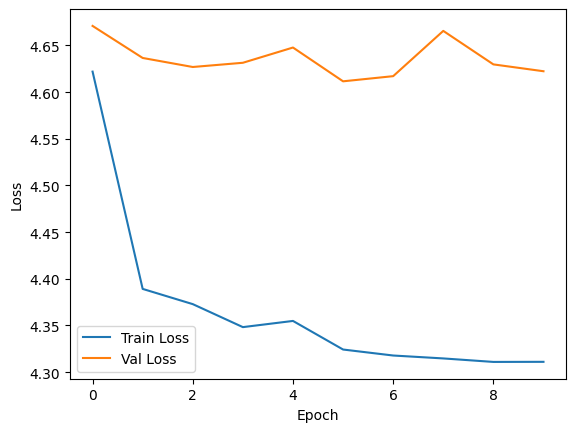

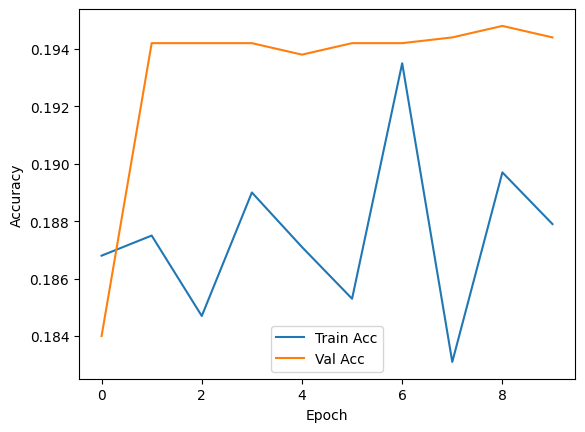

In [7]:
# Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training Loop
EPOCHS = 10
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for images, questions, answers in train_loader:
        images, questions, answers = images.to(device), questions.to(device), answers.to(device)
        optimizer.zero_grad()
        outputs = model(images, questions)
        loss = criterion(outputs, answers)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == answers).sum().item()
        train_total += answers.size(0)

    scheduler.step()
    train_acc = train_correct / train_total
    train_losses.append(train_loss / len(train_loader))
    train_accs.append(train_acc)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, questions, answers in val_loader:
            images, questions, answers = images.to(device), questions.to(device), answers.to(device)
            outputs = model(images, questions)
            loss = criterion(outputs, answers)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == answers).sum().item()
            val_total += answers.size(0)

    val_acc = val_correct / val_total
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

# Plot Results
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Question: Where is he looking?
True Answer: down
Predicted Answer: no


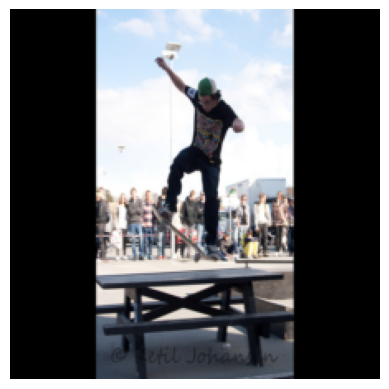

In [9]:
# Prediction Test
id_to_answer = {v: k for k, v in val_dataset.answer_to_id.items()}
model.eval()
with torch.no_grad():
    image, question, answer = val_dataset[0]
    image = image.unsqueeze(0).to(device)
    question = question.unsqueeze(0).to(device)
    output = model(image, question)
    pred_id = torch.argmax(output, dim=1).item()
    pred_answer = id_to_answer.get(pred_id, "<UNK>")
print("Question:", val_dataset.questions[0]["question"])
print("True Answer:", val_dataset.annotations[0]["multiple_choice_answer"])
print("Predicted Answer:", pred_answer)

# Display image (fixed denormalization)
import matplotlib.pyplot as plt
img = image.squeeze(0).cpu()  # [3, 224, 224]
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)  # Match shape
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
img = img * std + mean  # Denormalize in PyTorch
img = img.permute(1, 2, 0).numpy()  # [224, 224, 3] for plotting
img = img.clip(0, 1)
plt.imshow(img)
plt.axis("off")
plt.show()

Epoch 1/20, Train Loss: 4.2842, Train Acc: 0.1920, Val Loss: 4.6208, Val Acc: 0.1970
Epoch 2/20, Train Loss: 4.2781, Train Acc: 0.1919, Val Loss: 4.6209, Val Acc: 0.1948
Epoch 3/20, Train Loss: 4.2681, Train Acc: 0.1915, Val Loss: 4.6385, Val Acc: 0.1976
Epoch 4/20, Train Loss: 4.2513, Train Acc: 0.1928, Val Loss: 4.6348, Val Acc: 0.1926
Epoch 5/20, Train Loss: 4.2307, Train Acc: 0.1940, Val Loss: 4.6851, Val Acc: 0.1924
Epoch 6/20, Train Loss: 4.2158, Train Acc: 0.1914, Val Loss: 4.6651, Val Acc: 0.1954
Epoch 7/20, Train Loss: 4.1970, Train Acc: 0.1945, Val Loss: 4.6886, Val Acc: 0.1988
Epoch 8/20, Train Loss: 4.1849, Train Acc: 0.1976, Val Loss: 4.6883, Val Acc: 0.1902
Epoch 9/20, Train Loss: 4.1601, Train Acc: 0.1982, Val Loss: 4.7342, Val Acc: 0.1976
Epoch 10/20, Train Loss: 4.1275, Train Acc: 0.1957, Val Loss: 4.7376, Val Acc: 0.1976
Epoch 11/20, Train Loss: 4.1132, Train Acc: 0.1996, Val Loss: 4.7424, Val Acc: 0.1998
Epoch 12/20, Train Loss: 4.0755, Train Acc: 0.1958, Val Loss: 4

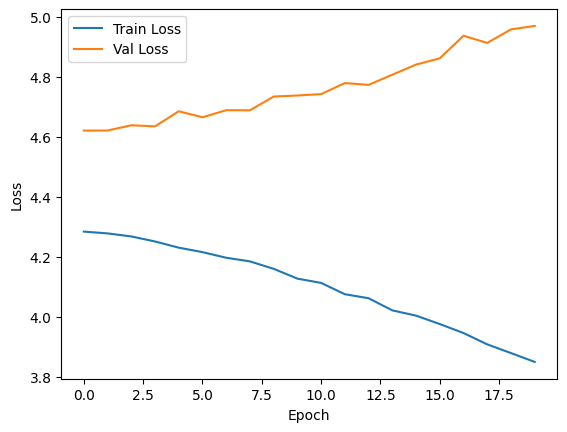

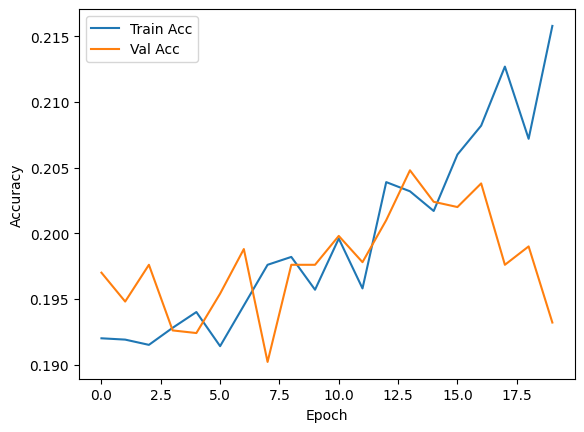

In [10]:
EPOCHS = 20
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for images, questions, answers in train_loader:
        images, questions, answers = images.to(device), questions.to(device), answers.to(device)
        optimizer.zero_grad()
        outputs = model(images, questions)
        loss = criterion(outputs, answers)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == answers).sum().item()
        train_total += answers.size(0)

    train_acc = train_correct / train_total
    train_losses.append(train_loss / len(train_loader))
    train_accs.append(train_acc)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, questions, answers in val_loader:
            images, questions, answers = images.to(device), questions.to(device), answers.to(device)
            outputs = model(images, questions)
            loss = criterion(outputs, answers)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == answers).sum().item()
            val_total += answers.size(0)

    val_acc = val_correct / val_total
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

# Plot
import matplotlib.pyplot as plt
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Question: Where is he looking?
True Answer: down
Predicted Answer: yes


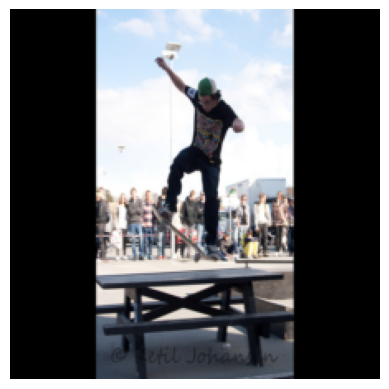

In [11]:
# Reverse answer_to_id for decoding
id_to_answer = {v: k for k, v in val_dataset.answer_to_id.items()}

# Pick a sample from validation set
model.eval()
with torch.no_grad():
    image, question, answer = val_dataset[0]  # First validation sample
    image = image.unsqueeze(0).to(device)
    question = question.unsqueeze(0).to(device)
    output = model(image, question)
    pred_id = torch.argmax(output, dim=1).item()
    pred_answer = id_to_answer.get(pred_id, "<UNK>")

# Print results
print("Question:", val_dataset.questions[0]["question"])
print("True Answer:", val_dataset.annotations[0]["multiple_choice_answer"])
print("Predicted Answer:", pred_answer)

# Display image
import matplotlib.pyplot as plt
img = image.squeeze(0).cpu()
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
img = img * std + mean
img = img.permute(1, 2, 0).numpy().clip(0, 1)
plt.imshow(img)
plt.axis("off")
plt.show()


Sample 1:
Question: Where is he looking?
True Answer: down
Predicted Answer: yes


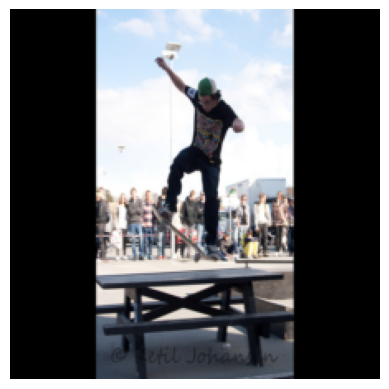


Sample 2:
Question: What are the people in the background doing?
True Answer: watching
Predicted Answer: yes


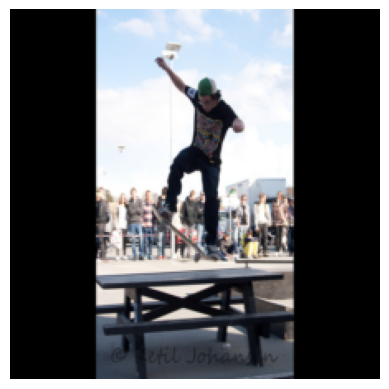


Sample 3:
Question: What is he on top of?
True Answer: picnic table
Predicted Answer: yes


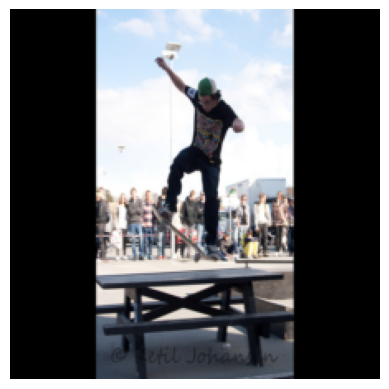


Sample 4:
Question: What website copyrighted the picture?
True Answer: foodiebakercom
Predicted Answer: yes


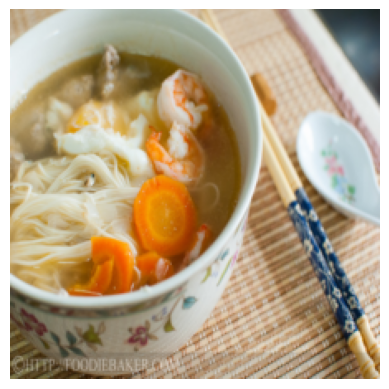


Sample 5:
Question: Is this a creamy soup?
True Answer: no
Predicted Answer: yes


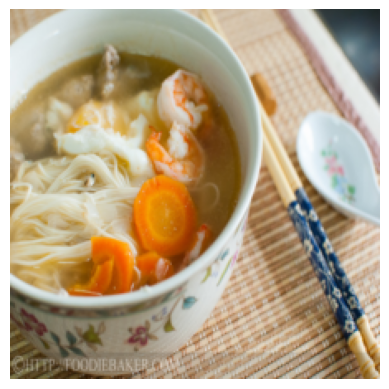

In [12]:
# Prediction Test on Multiple Examples
id_to_answer = {v: k for k, v in val_dataset.answer_to_id.items()}
model.eval()

num_samples = 5  # Test 5 examples
with torch.no_grad():
    for i in range(num_samples):
        image, question, answer = val_dataset[i]
        image = image.unsqueeze(0).to(device)
        question = question.unsqueeze(0).to(device)
        output = model(image, question)
        pred_id = torch.argmax(output, dim=1).item()
        pred_answer = id_to_answer.get(pred_id, "<UNK>")

        # Print results
        print(f"\nSample {i+1}:")
        print("Question:", val_dataset.questions[i]["question"])
        print("True Answer:", val_dataset.annotations[i]["multiple_choice_answer"])
        print("Predicted Answer:", pred_answer)

        # Display image
        img = image.squeeze(0).cpu()
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img * std + mean
        img = img.permute(1, 2, 0).numpy().clip(0, 1)
        plt.imshow(img)
        plt.axis("off")
        plt.show()